<h2><center>Anisotropic Absorption with Delta Radiance Distribution in 2D</center></h2>

This notebook explores the numerical solution of the anisotropic $P_1$ Approximation, when only absorbing media is present and when using a Delta distribution as closure (see survey chapter 2.2.2) in 2-dimensional domain. We will place a unit point light at the center of the domain and compare the solution against groundtruth results.

---------------------------
Let us consider the diffusion equation for anisotropic media, when being exposed to a delta distribution for the second moment of the radiance field (see section 2.2.2 in the survey):

$$\nabla\cdot\left[\left(M^{-1}\frac{\nabla\phi}{\lVert M^{-1}\nabla\phi \rVert}\right)\phi\right] = \frac{1}{2\pi}\mu_0\left[-\sigma_t + \sigma_s\right]\phi + Q_0$$

In 2d, $M$ is given as:

$$M=\frac{2}{2\pi}\left(-\mu_2\left[\sigma_t\right] + \mu_1\left[\sigma_s\mu_1\left[f_p\right]\right]\right) $$

In a purely absorbing media, $\sigma_s=0$ and therefore the equations above reduce to:

$$
\nabla\cdot\left[\left(M^{-1}\frac{\nabla\phi}{\lVert M^{-1}\nabla\phi \rVert}\right)\phi\right] = -\frac{1}{2\pi}\mu_0\left[\sigma_t\right]\phi + Q_0
$$

and

$$M=-\frac{2}{2\pi}\mu_2\left[\sigma_t\right]$$

---------------------------
If $\sigma_t$ is isotropic, its moments in 2d are:

$$
\mu_0[\sigma_t] = 2\pi\sigma_t
$$

$$
\mu_2[\sigma_t] = \frac{2\pi}{2}\sigma_t
$$

and the anisotropic equations above reduce to the isotropic solution:

$$M=-\sigma_t$$

$$
\nabla\cdot\left[-\frac{\nabla\phi}{\lVert\nabla\phi\rVert}\phi\right] = -\sigma_t\phi + Q_0
$$

---------------------------
Since the diffusion coefficient is a matrix, the discretization of the anisotropic $P_1$ equation for a delta radiance distribution is quite involved. Please see the notebook "anisotropic_absorption_2d_discretization" for all the details.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
import matplotlib.pyplot as plt
from util import *
import solver as solver

In [2]:
# setup domain ---
res = 161
size = 1.0
numIterations = 20500
domain = Domain2D(size, res)

# mu0_sigma_t: zero moment of the extinction coefficient at cell centers
def run_sim( domain, numIterations, mu0_sigma_t, Q, M_x, M_y, phi_boundary ):
    # setup/reset grids ---
    phi = np.zeros((domain.res, domain.res)) # scalar field for which we want to solve 

    # solve ---
    for step in range(numIterations):
        # call inner loop in c++
        #py::array_t<double> phi_array, // phi grid
        #py::array_t<double> Q_array, // grid of emission values
        #py::array_t<double> M_x_array, // grid of 2x2 matrices which represent anisotropy on faces perpendicular to x direction
        #py::array_t<double> M_y_array, // grid of 2x2 matrices which represent anisotropy on faces perpendicular to y direction
        #py::array_t<double> phi_boundary_array, // boundary values for phi
        #double h // voxelsize (in x and y)
        solver.iterate_2d_anisotropic_absorption(phi, mu0_sigma_t, Q, M_x, M_y, phi_boundary, domain.h)
        
    return phi

In [3]:
# SCENE: single pointlight -----------------------------------------------

# initialize field with zero moment of sigma_t at cell centers ---
# here we assume sigma_t to be homogeneous
sigma_t_constant = 5.0
mu0_sigma_t = np.ones((domain.res, domain.res))*sigma_t_constant*2.0*np.pi

# initialize emission field ---
Q = np.zeros((domain.res, domain.res))
pointlight1_center_ls = np.array([0.5, 0.5])
pointlight1_center_ws = domain.localToWorld(pointlight1_center_ls)
pointlight1_voxel = domain.voxelToIndex(domain.localToVoxel(pointlight1_center_ls))
Q[ pointlight1_voxel[0], pointlight1_voxel[1] ] = 1.0/(domain.h*domain.h)

# initialize anisotropy matrices ---
# currently we assume a homogeneous sigma_t and therefore get a spatially constant M matrix
M_inv = np.linalg.inv(-sigma_t_constant*np.identity(2))

# In each voxel we store two matrices. One at the left and another at the bottom cell face (staggered grid).
# M_x holds all matrices on the cell faces in x direction and M_y in y direction
M_x = np.zeros((domain.res+1, domain.res+1, 2, 2))
M_y = np.zeros((domain.res+1, domain.res+1, 2, 2))
for i in range(0, domain.res+1):
    for j in range(0, domain.res+1):
        #M_x[i, j] = -np.identity(2)
        #M_y[i, j] = -np.identity(2)
        M_x[i, j] = M_inv
        M_y[i, j] = M_inv
        

        
def compute_phi_groundtruth(pWS):
    ''' Compute groundtruth solution for single pointlight
    '''
    center = pointlight1_center_ws
    lightDir = center-pWS
    dist = np.linalg.norm(lightDir)
    if not dist>0:
        return 0.0

    lightDir = lightDir/dist
    power = 1.0

    radiance = power/(2.0*np.pi)

    L0 = radiance
    L0 *= geometry_term_2d(center, None, pWS, None)
    sigma_t = sigma_t_constant
    L0 *= np.exp(-sigma_t*dist)
    
    return L0

# compute groundtruth results for validation and boundary conditions ---
phi_groundtruth = domain.rasterize(compute_phi_groundtruth)
gradphi_groundtruth = domain.gradient(phi_groundtruth)

# initialize boundary values from groundtruth results ---
# we do this to see the solution without any boundary effects
phi_boundary = np.copy(phi_groundtruth)

# run simuation ---
phi = run_sim( domain, numIterations, mu0_sigma_t, Q, M_x, M_y, phi_boundary)

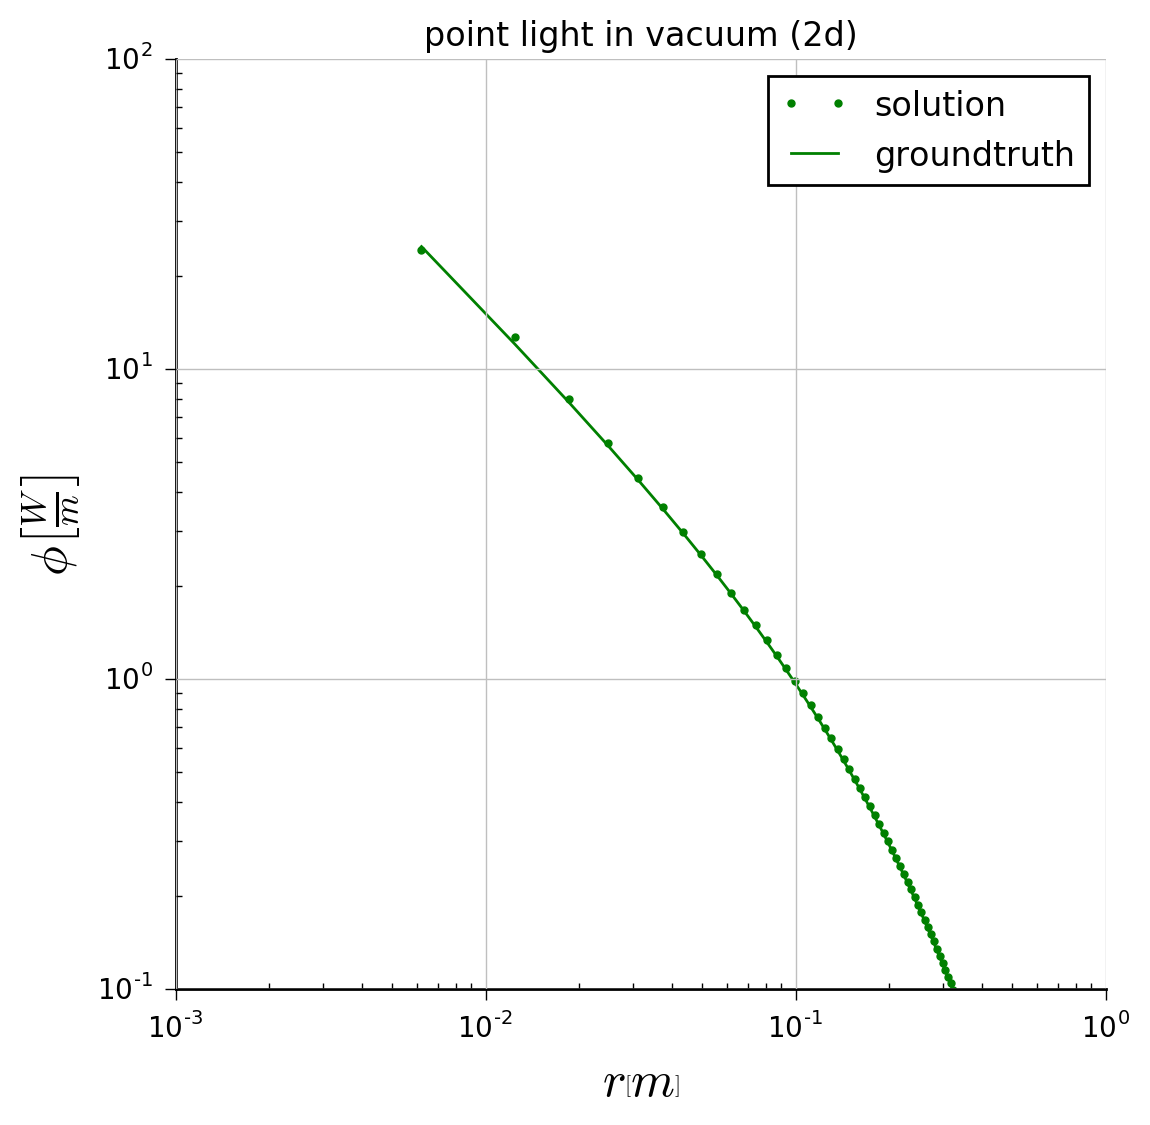

In [4]:
center_voxel = domain.voxelToIndex(domain.worldToVoxel(domain.localToWorld(np.array([0.5, 0.5]))))
domain_x = domain.rasterize( lambda pWS: pWS[0] )

domain2 = Domain2D(size, 512)
center_voxel2 = domain2.voxelToIndex(domain2.worldToVoxel(domain2.localToWorld(np.array([0.5, 0.5]))))
domain2_x = domain2.rasterize( lambda pWS: pWS[0] )
phi_groundtruth_mc = np.loadtxt("isotropic_absorption_2d/test.txt")

plt.figure(figsize=(6, 6))
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', direction='out')
ax.get_xaxis().tick_bottom()   # remove unneeded ticks 
ax.get_yaxis().tick_left()
plt.ylim([10.0e-2,10.0e1])
#plt.loglog( domain2_x[center_voxel2[0], center_voxel2[1]:], phi_groundtruth_mc[center_voxel2[0], center_voxel2[1]:], label="mc", color = 'r', linestyle=' ', marker='.', markersize=5 )
plt.loglog( domain_x[center_voxel[0], center_voxel[1]:], phi[center_voxel[0], center_voxel[1]:], label="solution", color = 'g', linestyle=' ', marker='.', markersize=5 )
plt.loglog( domain_x[center_voxel[0], center_voxel[1]:], phi_groundtruth[center_voxel[0], center_voxel[1]:], label="groundtruth", color = 'g' )
plt.title("point light in vacuum (2d)")
plt.xlabel(r'$r \left[m\right]$', fontsize=18)
plt.ylabel(r'$\phi \left[\frac{W}{m}\right]$', fontsize=18)
plt.grid(True, linestyle='-',color='0.75')
plt.legend(loc='best')
plt.draw()
plt.show()

domain = Domain2D(1.0, 512)
pointlight1_center_ws = np.array([0.0, 0.0])
density = 5.0
sggx = SGGX2D( 0.01, 0.0, 1.0 )

phi_mc = np.loadtxt("anisotropic_absorption_2d/test.txt")

def compute_phi_groundtruth(pWS):
    ''' Compute groundtruth solution for single pointlight
    '''
    center = pointlight1_center_ws
    lightDir = center-pWS
    dist = np.linalg.norm(lightDir)
    lightDir = lightDir/dist
    power = 1.0

    radiance = power/(2.0*np.pi)

    L0 = radiance
    L0 *= geometry_term_2d(center, None, pWS, None)
    sigma_t = density*sggx.projectedArea(lightDir)
    L0 *= np.exp(-sigma_t*dist)
    
    return L0

phi_groundtruth = domain.rasterize(compute_phi_groundtruth)

fig = plt.figure(figsize=(11, 11))

plt.subplot(221)
plt.imshow(phi_mc, interpolation="nearest", extent = [domain.bound_min[0], domain.bound_max[0], domain.bound_min[1], domain.bound_max[1]])
plt.subplot(222)
plt.imshow(phi_groundtruth, interpolation="nearest", extent = [domain.bound_min[0], domain.bound_max[0], domain.bound_min[1], domain.bound_max[1]])


#plt.imshow(phi, interpolation="nearest", extent = [domain.bound_min[0], domain.bound_max[0], domain.bound_min[1], domain.bound_max[1]])

plt.subplot(223)
# 1d slice plot
center_voxel = domain.voxelToIndex(domain.worldToVoxel((domain.bound_max+domain.bound_min)/2.0))
domain_x = domain.rasterize( lambda pWS: pWS[0] )

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', direction='out')
ax.get_xaxis().tick_bottom()   # remove unneeded ticks 
ax.get_yaxis().tick_left()
plt.ylim([10.0e-2,10.0e1])
#plt.loglog( domain_x[center_voxel[0], center_voxel[1]:], phi[center_voxel[0], center_voxel[1]:], label="solution", color = 'g', linestyle=' ', marker='.', markersize=5 )
plt.loglog( domain_x[center_voxel[0], center_voxel[1]:], phi_mc[center_voxel[0], center_voxel[1]:], label="mc", color = 'r', linestyle=' ', marker='.', markersize=5 )
plt.loglog( domain_x[center_voxel[0], center_voxel[1]:], phi_groundtruth[center_voxel[0], center_voxel[1]:], label="groundtruth", color = 'g' )

plt.grid(True, linestyle='-',color='0.75')
plt.legend(loc='best')


plt.show()